Exercise
- You will be provided with a pickle file that contains all the embeddings
- The structure of the dictionary saved in the pickle file is:
{'syndrome_id': { 'subject_id': {'image_id': [320x1 encoding]}}}
-
If you get "numpy.core._multiarray_umath" error when loading the pickle file, please
upgrade your numpy package.
-
The steps to perform:
1. Load the pickle file and:
a) Calculate cosine distance from each test set vector to the gallery (training)
vectors
b) Classify each image (vector) or each subject to syndrome IDs based on a
clustering algorithm
c) Calculate and report AUCd) Write a short paragraph with your conclusions (can we use this method to
distinguish between those syndromes?)
2. Please answer the following questions in writing:
a) How would you create these embeddings? How would you optimize and
measure the accuracy of the whole solution?
b) Besides the patient photo, we optionally allow geneticists to select phenotypic
abnormalities that are present/absent (e.g. long face, tall stature, etc.). How
would you design a research project on leveraging these features to improve
the syndrome classification results?

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
import umap
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import utils
%load_ext autoreload
%autoreload 2

In [2]:
with open("mini_gm_public_v0.1.p", 'rb') as f:
    res = pickle.load(f)

# Data Preprocessing

Create dataframe with entire dataset

In [3]:
df = pd.DataFrame(columns = ['syndrome', 'subject', 'imgid', 'img'])

for syndrome, el1 in res.items():
    for subject, el2 in el1.items():
        for imgid, img in el2.items():
            df.loc[df.shape[0]] = [syndrome, subject, imgid, img]
print(df.shape)
df.head()

(1116, 4)


,syndrome,subject,imgid,img
0,300000082,595,3543,"[-0.03718013, 1.741486, 1.2061033, -0.45145318..."
1,300000082,2638,1633,"[2.4249947, 0.17991967, 2.9503245, 0.37993023,..."
2,300000082,734490,742992,"[-1.7893314, -0.21621145, 0.43431538, -0.55232..."
3,300000082,2770,1812,"[-1.1436926, -0.7146209, 0.31948757, 0.4556819..."
4,300000082,2642,1801,"[0.81417066, 1.3274913, 0.84728503, -0.2123311..."


In [4]:
df.describe()

,syndrome,subject,imgid,img
count,1116,1116,1116,1116
unique,10,941,1116,1116
top,300000034,8980,3543,"[-0.03718013, 1.741486, 1.2061033, -0.45145318..."
freq,210,11,1,1


In [5]:
df['syndrome'].value_counts()

300000034    210
300000080    198
100192430    136
300000007    115
300000082     98
100610443     89
300000018     74
100180860     67
100610883     65
700018215     64
Name: syndrome, dtype: int64

# Encode syndrom as numeric label

In [6]:
df['syndrome'] = preprocessing.LabelEncoder().fit_transform(df['syndrome'].values)

df['syndrome'].values.shape, np.arange(len(df))

((1116,), array([   0,    1,    2, ..., 1113, 1114, 1115]))

# Train test split

In [7]:
train_idx, test_idx, y_train, y_test = train_test_split(
    np.arange(len(df)),
    df['syndrome'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['syndrome'].values
)

print('Train/test size', len(train_idx), len(test_idx))

Train/test size 892 224


In [8]:
vectors = np.stack(df['img'].values)

# Compute distance matrix

In [9]:
D = squareform(pdist(vectors, metric='cosine'))

## Calculate cosine distance from each test set vector to the gallery (training) vectors

In [10]:
D[train_idx][:, test_idx].shape

(892, 224)

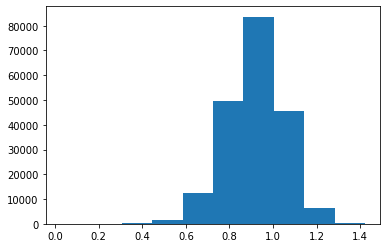

In [11]:
plt.hist(D[train_idx][:, test_idx].reshape(-1));

# Visualization

For complementarity, use 2 dimensionality reduction techniques

In [12]:
reduced_umap = umap.UMAP().fit_transform(vectors)

reduced_pca = PCA(n_components=2).fit_transform(vectors)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0, 0.5, 'PCA COMPONENT 2')

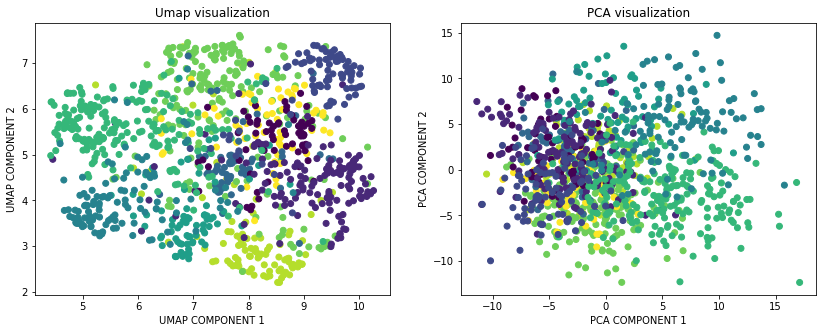

In [13]:
plt.figure(figsize = (14, 5))

plt.subplot(121)
plt.title('Umap visualization')
plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], c = df['syndrome'].values)
plt.xlabel('UMAP COMPONENT 1')
plt.ylabel('UMAP COMPONENT 2')

plt.subplot(122)
plt.title('PCA visualization')
plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], c = df['syndrome'].values)
plt.xlabel('PCA COMPONENT 1')
plt.ylabel('PCA COMPONENT 2')

# Clustering

Approach 1: KMeans
Approach 2: Hierarchical clustering

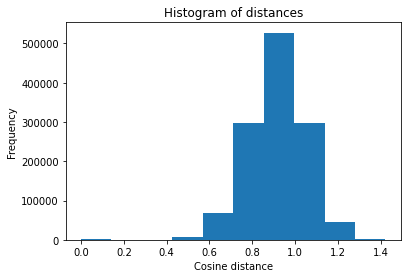

In [14]:
plt.title('Histogram of distances')
plt.hist(D.reshape(-1))
plt.xlabel('Cosine distance')
plt.ylabel('Frequency');

In [15]:
y = df['syndrome'].values

In [16]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(vectors[train_idx])

In [17]:
pred_train = kmeans.predict(vectors[train_idx])
pred_test = kmeans.predict(vectors[test_idx])
adjusted_rand_score(y[train_idx], pred_train), adjusted_rand_score(y[test_idx], pred_test)

(0.42037973300675147, 0.45965446435311375)

# Implement a baseline greedy approach to match the predicted labels with the ground truth labels on the train set

In [18]:
pred_to_gt = utils.label_matching(y[train_idx], pred_train)

Predicted cluster 0 corresponds to gt 1 and has AUC 0.7859151464023341
Predicted cluster 1 corresponds to gt 8 and has AUC 0.8830403830403829
Predicted cluster 2 corresponds to gt 6 and has AUC 0.5958464877663773
Predicted cluster 3 corresponds to gt 9 and has AUC 0.8140169266279639
Predicted cluster 4 corresponds to gt 4 and has AUC 0.8754347826086957
Predicted cluster 5 corresponds to gt 2 and has AUC 0.9379149439879227
Predicted cluster 6 corresponds to gt 0 and has AUC 0.8336648103951206
Predicted cluster 7 corresponds to gt 7 and has AUC 0.7693839892387817
Predicted cluster 8 corresponds to gt 6 and has AUC 0.7751414101552223
Predicted cluster 9 corresponds to gt 5 and has AUC 0.8664923596557268
Average aucs 0.813685123987853


In [19]:
matched_pred_train = np.array([pred_to_gt[el] for el in pred_train])
matched_pred_test = np.array([pred_to_gt[el] for el in pred_test])

## AUC evaluation on train set

In [20]:
utils.evaluate(y[train_idx], matched_pred_train)

ARI score:  0.44227569682042295
Ground truth class 0 has AUC 0.8336648103951206
Ground truth class 1 has AUC 0.7859151464023341
Ground truth class 2 has AUC 0.9379149439879227
Ground truth class 3 has AUC 0.5
Ground truth class 4 has AUC 0.8754347826086957
Ground truth class 5 has AUC 0.8664923596557268
Ground truth class 6 has AUC 0.8709878979215996
Ground truth class 7 has AUC 0.7693839892387817
Ground truth class 8 has AUC 0.8830403830403829
Ground truth class 9 has AUC 0.8140169266279639
Average aucs 0.8136851239878528
Confusion matrix
[[ 39   0   2   0   0   2   9   1   1   0]
 [ 17  64   5   0   0   2  13   3   2   3]
 [  2   0  64   0   0   0   5   0   0   0]
 [ 12   0   2   0   0  27   7   4   0   0]
 [  1   0   1   0  70   7  12   1   0   0]
 [  1   1   1   0   4  47   4   1   0   0]
 [  1   4   2   0   3   5 146   4   2   1]
 [  6   4   8   0   0   3  29  89   7  12]
 [  0   3   0   0   1   6   4   3  61   0]
 [  6   0   0   0   0   1   9   1   1  33]]


In [21]:
utils.evaluate(y[test_idx], matched_pred_test)

ARI score:  0.4294369869267826
Ground truth class 0 has AUC 0.8970105723660227
Ground truth class 1 has AUC 0.7886820830983267
Ground truth class 2 has AUC 0.9600862998921251
Ground truth class 3 has AUC 0.5
Ground truth class 4 has AUC 0.8186242699545749
Ground truth class 5 has AUC 0.8784688995215312
Ground truth class 6 has AUC 0.8782051282051281
Ground truth class 7 has AUC 0.7418478260869565
Ground truth class 8 has AUC 0.9450980392156862
Ground truth class 9 has AUC 0.7934742982136347
Average aucs 0.8201497416553988
Confusion matrix
[[11  0  0  0  0  0  2  0  0  0]
 [ 5 16  2  0  0  0  3  1  0  0]
 [ 0  0 17  0  0  0  1  0  0  0]
 [ 3  1  1  0  0  6  2  0  0  0]
 [ 0  1  0  0 15  1  5  0  0  1]
 [ 1  0  0  0  0 12  2  0  0  0]
 [ 0  0  1  0  1  1 38  1  0  0]
 [ 2  1  1  0  2  0  7 20  2  5]
 [ 0  0  0  0  0  1  0  1 18  0]
 [ 0  0  0  0  0  0  5  0  0  8]]


In [22]:
model = GaussianMixture(n_components=10, random_state=0).fit(vectors[train_idx])

pred_train = model.predict(vectors[train_idx])
pred_test = model.predict(vectors[test_idx])
adjusted_rand_score(y[train_idx], pred_train), adjusted_rand_score(y[test_idx], pred_test)

(0.3507075132468972, 1.2243068994591012e-05)

d) Write a short paragraph with your conclusions (can we use this method to distinguish between those syndromes?)

The selected method manages to correctly distingush 9/10 syndromes with AUCs above 0.74. However, syndrom 4 is higly confused with syndrom 0 and syndrom 6.

a) How would you create these embeddings? How would you optimize and measure the accuracy of the whole solution?

The used embeddings can be generated either as one of the final layers of a classifier trained to distinguish between syndromes. However, this baseline approach does not guarantee that the embedding space has properties facilitating future clustering (e.g. smoothness, interpolability).   

One improved approach would be to use unsupervised or self-supervised techniques. The supervised contrastive learning (https://arxiv.org/abs/2004.11362), is one approach which is expected to create an embedding space with an improved internal clustering quality.


b) Besides the patient photo, we optionally allow geneticists to select phenotypic abnormalities that are present/absent (e.g. long face, tall stature, etc.). How would you design a research project on leveraging these features to improve the syndrome classification results?

Using multi-modal models leveraging a fusion model tolerant to missing data is one strategy allowing us to combine a number of different inputs without enforcing their presence. Methods such as https://ieeexplore.ieee.org/document/9429478 also provide generation for missing views, application which brings an added value in itself.

# Hierarchical clustering

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [24]:
Z = linkage(vectors, 'complete',  metric='cosine')

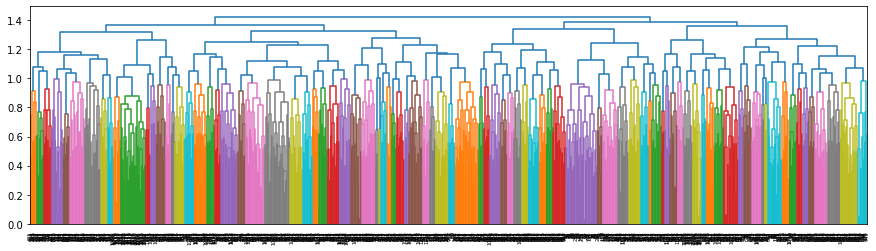

In [25]:
plt.figure(figsize = (15, 4))
dendrogram(Z);

In [26]:
df['syndrome'].unique().shape

(10,)

In [27]:
cut_threshold = 1.26
pred = fcluster(Z, cut_threshold, criterion='distance')
print(np.unique(pred).shape)
Counter(pred)

(12,)


Counter({12: 104,
         8: 128,
         11: 68,
         6: 116,
         10: 73,
         2: 58,
         3: 38,
         4: 221,
         1: 110,
         7: 116,
         9: 29,
         5: 55})

In [28]:
adjusted_rand_score(df['syndrome'].values, pred)

0.2591686829343058

# Label matching

In [29]:
from tqdm.notebook import tqdm
import numpy as np
from itertools import permutations, product
from sklearn.metrics import accuracy_score, auc

def source_to_target_labels(source_labels, target_labels):
    """Rename prediction labels (clustered output) to best match true labels."""

    source_labels, target_labels = np.array(source_labels), np.array(target_labels)
    assert source_labels.ndim == 1 == target_labels.ndim
#     assert len(source_labels) == len(target_labels)
    unique_source_labels = np.unique(source_labels)
    accuracy = -1
    if len(np.unique(source_labels)) != len(np.unique(target_labels)):
        perms = product(np.unique(target_labels), repeat = len(unique_source_labels))
    else:
        perms = np.array(list(permutations(unique_source_labels)))
    best_perm = None
    remapped_labels = target_labels
    for perm in tqdm(perms):
        cmap = dict(zip(unique_source_labels, perm))
        f = lambda x: cmap[x]
        flipped_labels = np.vectorize(f)(source_labels)
        testAcc = accuracy_score(target_labels, flipped_labels)
        if testAcc > accuracy:
            accuracy = testAcc
            remapped_labels = flipped_labels
            best_perm = perm

    source_to_target = dict(zip(unique_source_labels, best_perm))
    return remapped_labels, source_to_target, accuracy



prediction   = [1, 1, 1, 1, 0, 0, 2, 3, 4]
ground_truth = [0, 1, 1, 2, 2, 2, 0, 0, 0]

source_to_target_labels(prediction, ground_truth)

0it [00:00, ?it/s]

(array([1, 1, 1, 1, 2, 2, 0, 0, 0]),
 {0: 2, 1: 1, 2: 0, 3: 0, 4: 0},
 0.7777777777777778)